<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-records" data-toc-modified-id="Load-records-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load records</a></span></li><li><span><a href="#Dataset-and-transforms" data-toc-modified-id="Dataset-and-transforms-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset and transforms</a></span></li><li><span><a href="#DataLoaders" data-toc-modified-id="DataLoaders-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>DataLoaders</a></span></li><li><span><a href="#Metrics,-model-and-learner" data-toc-modified-id="Metrics,-model-and-learner-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Metrics, model and learner</a></span></li><li><span><a href="#Logger-and-train" data-toc-modified-id="Logger-and-train-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Logger and train</a></span></li><li><span><a href="#Show-results" data-toc-modified-id="Show-results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Show results</a></span></li></ul></div>

## Introduction

This is the dataset used in the pytorch MaskRCNN tutorial available [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)  
  
Check our [wandb repo](https://app.wandb.ai/lgvaz/PennFudan) for our benchmarks.

## Imports

In [1]:
from mantisshrimp.all import *

## Load records

In [2]:
source = Path('/home/lgvaz/.data/PennFudanPed/')

In [3]:
class PersonImageParser(ImageParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        # Get size
        sz = self.lines.filter(lambda o: o.startswith('Image size (X x Y x C)'))[0]
        sz = re.search(r'\d{3,4}\sx\s\d{3,4}\sx\s3', sz).group()
        self.sz = lmap(int, sz.split('x'))
        
    def iid(self, o): return self.i
    def file_path(self, o):
        fp = self.lines.filter(lambda o: o.startswith('Image filename'))[0]
        fp = re.findall(r'"(.*)"', fp)[0]
        return self.source.parent/fp
    
    def width(self, o):  return self.sz[0]
    def height(self, o): return self.sz[1]

In [4]:
class PersonAnnotationParser(AnnotationParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        ln = self.lines.filter(lambda o: o.startswith('Objects with ground truth'))[0]
        self.n = int(re.findall('\d+', ln)[0])
        
    def iid(self, o): return self.i
    def oid(self, o): return [0]*self.n
    def iscrowd(self, o): return [0]*self.n
        
    def bbox(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Bounding box'))
        bboxes = []
        for bbox in lines:
            bbox = re.findall(r'(\d+,\s\d+)', bbox)
            bbox = lmap(lambda o: lmap(int, o.split(',')), bbox)
            bbox = np.array(bbox).flat
            bboxes.append(BBox.from_xyxy(*bbox))
        return bboxes
    
    def seg(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Pixel mask for object'))
        line = lines[0] # All lines contain the same mask
        fp = self.source.parent/re.findall(r'"(.+)"', line.split(':')[-1])[0]
        return MaskFile(fp)

In [5]:
fns = get_files(source/'Annotation', extensions='.txt')

In [6]:
catmap = CategoryMap([Category(0, 'person')])

In [7]:
parser = DataParser(fns, source, catmap, img_parser=PersonImageParser, annot_parser=PersonAnnotationParser)
train_rs,valid_rs = parser.parse()


Removed 0 images that don't have annotations


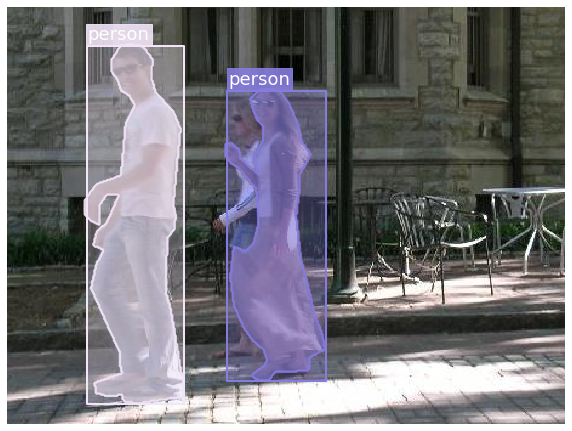

In [8]:
show_record(r=random.choice(train_rs), catmap=catmap)

## Dataset and transforms

In [9]:
tfm = AlbuTfm([A.HorizontalFlip(),
#                A.Rotate(p=.7, limit=10, border_mode=cv2.BORDER_CONSTANT),
#                A.RGBShift(), A.RandomBrightness(), A.RandomContrast(),
#                A.RandomFog(.1,.5),
              ])

In [10]:
train_ds = Dataset(train_rs, tfm)
valid_ds = Dataset(valid_rs)

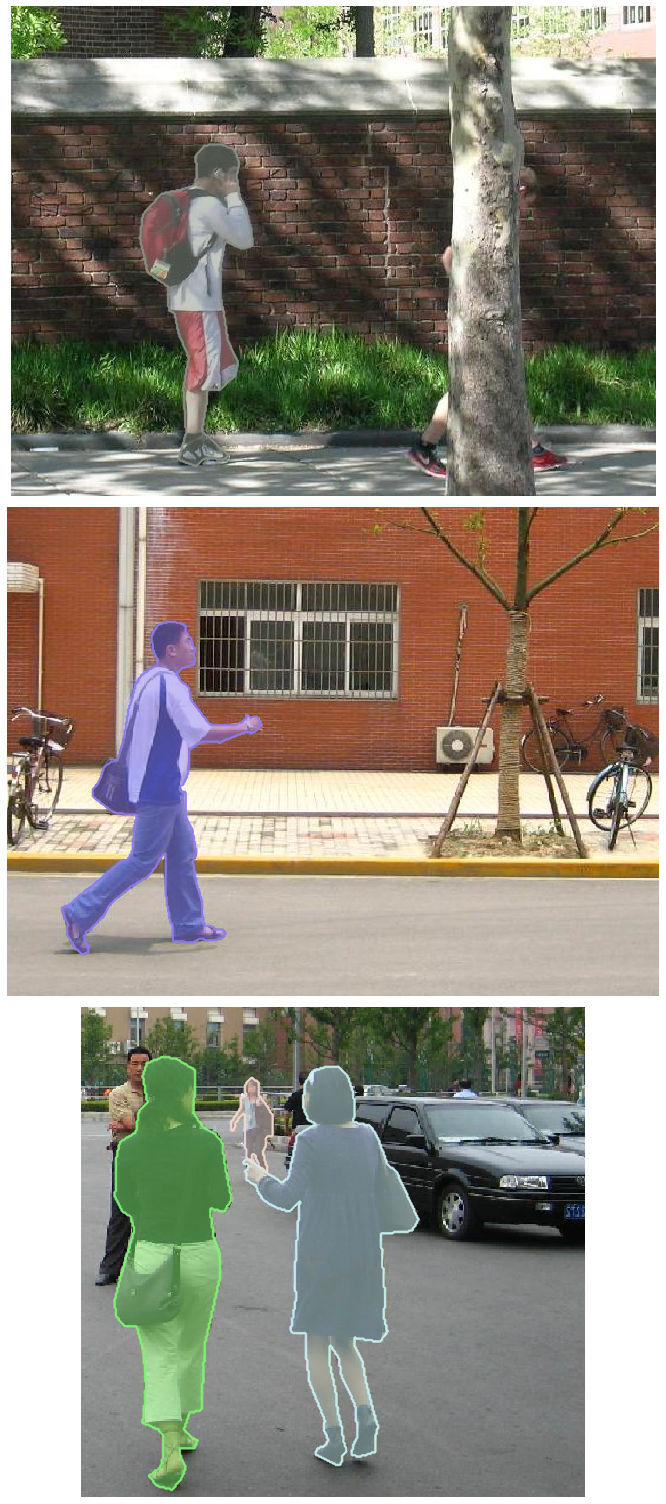

In [11]:
items = random.choices(train_ds, k=3) # Different items
# items = [train_ds[3] for _ in range(3)] # Same item
grid2([partial(show_item, item, bbox=False, label=False, catmap=catmap) for item in items])

## DataLoaders

In [12]:
train_dl = RCNNDataLoader(train_ds, batch_size=2, num_workers=8)
valid_dl = RCNNDataLoader(valid_ds, batch_size=4, shuffle=False, num_workers=8)

## Metrics, model and learner

In [13]:
metrics = [COCOMetric(valid_rs, catmap)]


creating index...
index created!


In [14]:
model = MantisMaskRCNN(len(catmap), metrics=metrics)

In [15]:
opt_func = partial(SGD, momentum=.9, weight_decay=5e-4)
# opt_func = partial(Adam, weight_decay=5e-4)

In [16]:
# If wandb is installed
logger = loggers.WandbLogger('freezed SGD onecycle.25 lr:5e-3 wd:5e-4 aug:flip',
                             save_dir='logs', project='PennFudan')

In [17]:
learn = Learner(model, train_dl, valid_dl, opt_fn=opt_func, logger=logger)

## Logger and train

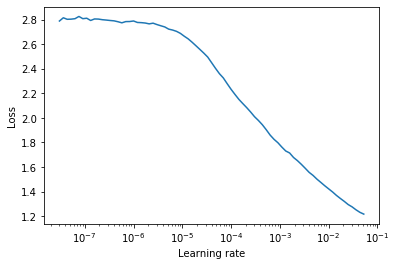

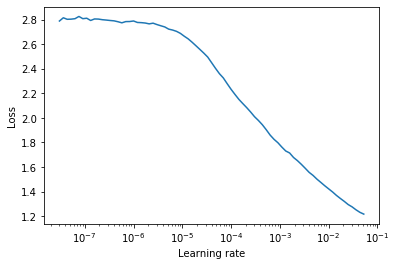

In [23]:
finder = learn.lr_find()
finder.plot()

In [21]:
learn.fit_one_cycle(10, 5e-3, checkpoint_callback=checkpoint_cb)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]



    | Name                                       | Type                     | Params
------------------------------------------------------------------------------------
0   | m                                          | MaskRCNN                 | 43 M  
1   | m.transform                                | GeneralizedRCNNTransform | 0     
2   | m.backbone                                 | BackboneWithFPN          | 26 M  
3   | m.backbone.body                            | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                      | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                        | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                       | ReLU                     | 0     
7   | m.backbone.body.maxpool                    | MaxPool2d                | 0     
8   | m.backbone.body.layer1                     | Sequential               | 212 K 
9   | m.backbone.body.layer1.0                   | Bottleneck   

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 

Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.595
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.570
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.623
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.629
 

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


## Show results

In [16]:
learn.show_results()